In [1]:
import toml
from radionets.dl_framework.data import load_data
from radionets.evaluation.plotting import plot_target, plot_inp_tar

In [2]:
%matplotlib inline

# Dataset Simulation

This jupyter notebook gives an overview of the dataset creation using the radionets framework. Different simulation options are explained and a toy dataset is created. This toy dataset is used in the next notebook to explain the training process. For the simulation the executable `radionets_simulations <...>` is used, which is added to your path when installing the radionets package. 

## Simulation Config

All necessary options to create a dataset can be specified in the `simulation_config.toml`. For a costum analysis, it is recommended to create a copy of the `default_simulation_config.toml` in your own working directory. For this example, we will use the `default_simulation_config.toml`. Let's have a look what kind of options are available inside the config file.

In [3]:
config_path = "./default_simulation_config.toml"
sim_conf = toml.load(config_path)
sim_conf.keys()

dict_keys(['title', 'mode', 'paths', 'mnist', 'gaussians', 'image_options', 'sampling_options'])

The config file is divided into following parts:
* mode
* paths
* mnist
* gaussians
* image_options
* sampling_options

### mode

The only option here is to enable the `quiet` option. This is necessary when you are running the analysis on a machine with queuing systems like `slurm`. It will disable all user input prompts.

In [4]:
sim_conf["mode"]

{'quiet': True}

### paths

In this section, you can specify the path to save the data and the data format. At  the moment the only available format is `hdf5`.

In [5]:
sim_conf["paths"]

{'data_path': './example_data/', 'data_format': 'h5'}

### mnist

It is possible to create a toy dataset based on the images of handwritten digits from the mnist dataset. Taking the mnist digits as resource can be enabled by setting `simulate` to `true`. It is not recommended to experiment with mnist anymore. This option is only available because of historical reasons. Note that you can only use `mnist` in the case `gaussians` is disabled.

In [6]:
sim_conf["mnist"]

{'simulate': False, 'resource': '../../resources/mnist.pkl.gz'}

### gaussians

In this section, you can enable the dataset creation based on Gaussian sources. These can be pointsources and extended Gaussian sources or a mixture. You can select the simulation of Gaussian sources by setting `simulate` to `true`. The different source types can be selected by setting their keywords to `true`. Furthermore, the number of sources or the number of components in the extended sources can be specified. In case of extended sources it is a range from which a random number is selected.

In [7]:
sim_conf["gaussians"]

{'simulate': True,
 'pointsources': False,
 'num_pointsources': 10,
 'pointlike_gaussians': False,
 'num_pointlike_gaussians': 5,
 'extended_gaussians': True,
 'num_components': [4, 10]}

#### Pointsources

In [8]:
!ls ./example_data/

ls: cannot access './example_data/': No such file or directory


In [9]:
%%capture
!radionets_simulations .rc/simulations/simulation_pointsources.toml

point_path = "./example_data/pointsources/"
pointsources = load_data(point_path, "train")

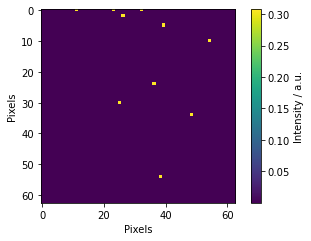

In [10]:
plot_target(pointsources)

#### Pointlike Gaussians

In [11]:
%%capture
!radionets_simulations .rc/simulations/simulation_pointlike_gaussians.toml

pointlike_path = "./example_data/pointlike_gaussians/"
pointlike_gaussians = load_data(pointlike_path, "train")

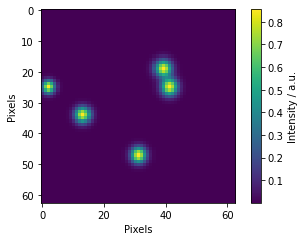

In [12]:
plot_target(pointlike_gaussians)

#### Extended Gaussians

In [13]:
%%capture
!radionets_simulations .rc/simulations/simulation_extended_gaussians.toml

extended_path = "./example_data/extended_gaussians/"
extended_gaussians = load_data(extended_path, "train")

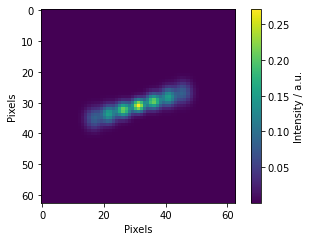

In [14]:
plot_target(extended_gaussians)

#### Mix of All

In [15]:
%%capture
!radionets_simulations .rc/simulations/simulation_mix.toml

mix_path = "./example_data/mix_gaussians/"
mix_gaussians = load_data(mix_path, "train")

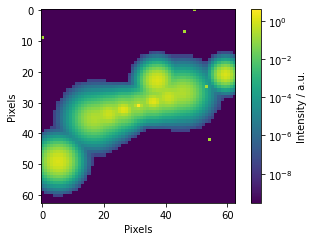

In [16]:
plot_target(mix_gaussians, log=True)

### image_options

In this section, different image options can be set. All simulated images are saved in bundles. The number of bundles for the train, valid and test dataset can be specified. Furthermore, the number of images inside one bundle and the image size in pixel can be chosen. All simulated images are quadratic. As a last option, it is possible to add random noise values to all pixels.

In [17]:
sim_conf["image_options"]

{'bundles_train': 5,
 'bundles_valid': 1,
 'bundles_test': 1,
 'bundle_size': 500,
 'img_size': 63,
 'noise': False}

### sampling_options

There are different sampling options available. You can decide between creating datasets where the `x` images are saved in Fourier space and the `y` images in the local space or datasets where both `x` and `y` are saved in Fourier space. This can be specified with the keyword `fourier`. Additionally, there is the option to use the real and imaginary parts of the complex numbers or to transform them into amplitude and phase.

For the sampling, a layout of a real radio interferometer is used. At the moment, only the layout of the VLBA is available. With the hlep of this layout sampling masks are created to simulate incomplete Fourier spectra. This can be done by using a `specific_mask` for all images with specified starting `lon`, starting `lat` and number of sample `steps` or by drawing a new random mask for every image. In the example dataset, all observations start at `lon = -80`, `lat = 50` and will last for `50 time steps`.

With the `keep_fft_files` option one can specify to delete all fft files after creating the simulations to save disk space.

The `source_list` options allows it to save a list of sources instead of a source image. This option is only available when `fourier = false`.

The `compressed` option will be deleted soon. 

In [18]:
sim_conf["sampling_options"]

{'fourier': True,
 'real_imag': False,
 'amp_phase': True,
 'antenna_config': 'vlba',
 'specific_mask': True,
 'lon': -80,
 'lat': 50,
 'steps': 50,
 'keep_fft_files': True,
 'source_list': False,
 'compressed': False}

### Fourier = False: Target Images in Local Space

In [19]:
%%capture
!radionets_simulations .rc/simulations/simulation_local.toml

local_path = "./example_data/local/"
local = load_data(local_path, "train")

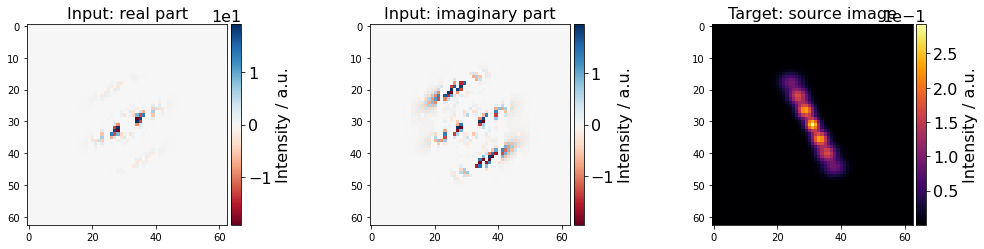

In [20]:
plot_inp_tar(local)

### Fourier = True: Target Images in Fourier Space

In [21]:
%%capture
!radionets_simulations .rc/simulations/simulation_fourier_real.toml

fourier_real_path = "./example_data/fourier_real/"
fourier_real = load_data(fourier_real_path, "train", fourier=True)

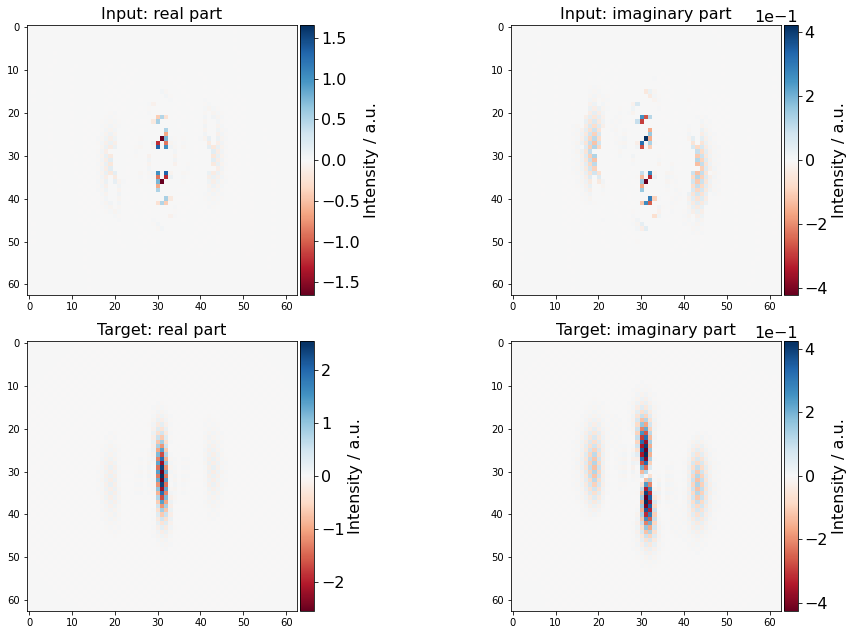

In [22]:
plot_inp_tar(fourier_real, fourier=True)

### Fourier = True & amp_phase = True: Target Images in Fourier Space Converted Into Amplitude and Phase

When using `amp_phase` the amplitude is rescaled during the dataset creation. This rescaling is done with the function:

amp_scaled = ( log10( amp + 1e-10 ) / 10) + 1

The scaling has to be taken into account when doing the inverse Fourier transformation for the source reconstruction in local space. Additinally, amplitude and phase must first be converted into real and imaginary parts.

In [23]:
%%capture
!radionets_simulations .rc/simulations/simulation_fourier_amp.toml

fourier_amp_path = "./example_data/fourier_amp/"
fourier_amp = load_data(fourier_amp_path, "train", fourier=True)

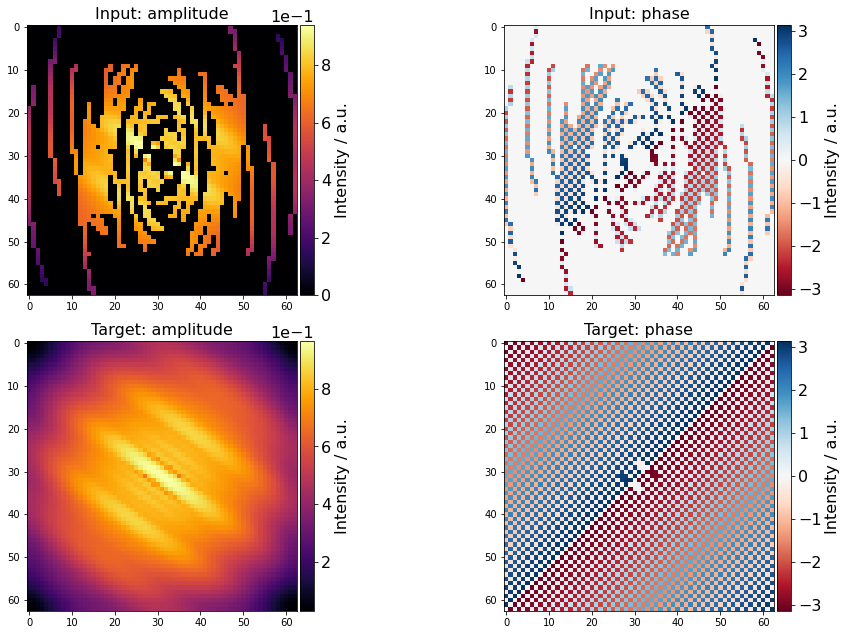

In [24]:
plot_inp_tar(fourier_amp, fourier=True, amp_phase=True)

## Create the Default Simulation

Starting the simulation script with the default simulation config. 

In [25]:
!radionets_simulations ./default_simulation_config.toml

Found existing fft_files!
Overwriting old fft_files!
Create fft_images from gaussian data set! 

Adding extended gaussian sources.

 Simulation config:
{'data_path': './example_data/', 'data_format': 'h5', 'type': 'gaussians', 'num_pointsources': None, 'num_pointlike_gaussians': None, 'num_components': [4, 10], 'bundles_train': 5, 'bundles_valid': 1, 'bundles_test': 1, 'bundle_size': 500, 'img_size': 63, 'noise': False, 'amp_phase': True, 'real_imag': False, 'source_list': False, 'antenna_config': 'vlba', 'specific_mask': True, 'lon': -80, 'lat': 50, 'steps': 50, 'fourier': True, 'compressed': False, 'keep_fft_files': True} 

Starting simulation of fft_files!
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]
Start sampling fft_files!

 Sampling train data set.

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.29it/s]

 Sampling valid data set.

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]

 Sampl